# 转置卷积
:label:`sec_transposed_conv`

到目前为止，我们所见到的卷积神经网络层，例如卷积层（ :numref:`sec_conv_layer`）和汇聚层（ :numref:`sec_pooling`），通常会减少下采样输入图像的空间维度（高和宽）。
然而如果输入和输出图像的空间维度相同，在以像素级分类的语义分割中将会很方便。
例如，输出像素所处的通道维可以保有输入像素在同一位置上的分类结果。

为了实现这一点，尤其是在空间维度被卷积神经网络层缩小后，我们可以使用另一种类型的卷积神经网络层，它可以增加上采样中间层特征图的空间维度。
在本节中，我们将介绍
*转置卷积*（transposed convolution） :cite:`Dumoulin.Visin.2016`，
用于逆转下采样导致的空间尺寸减小。
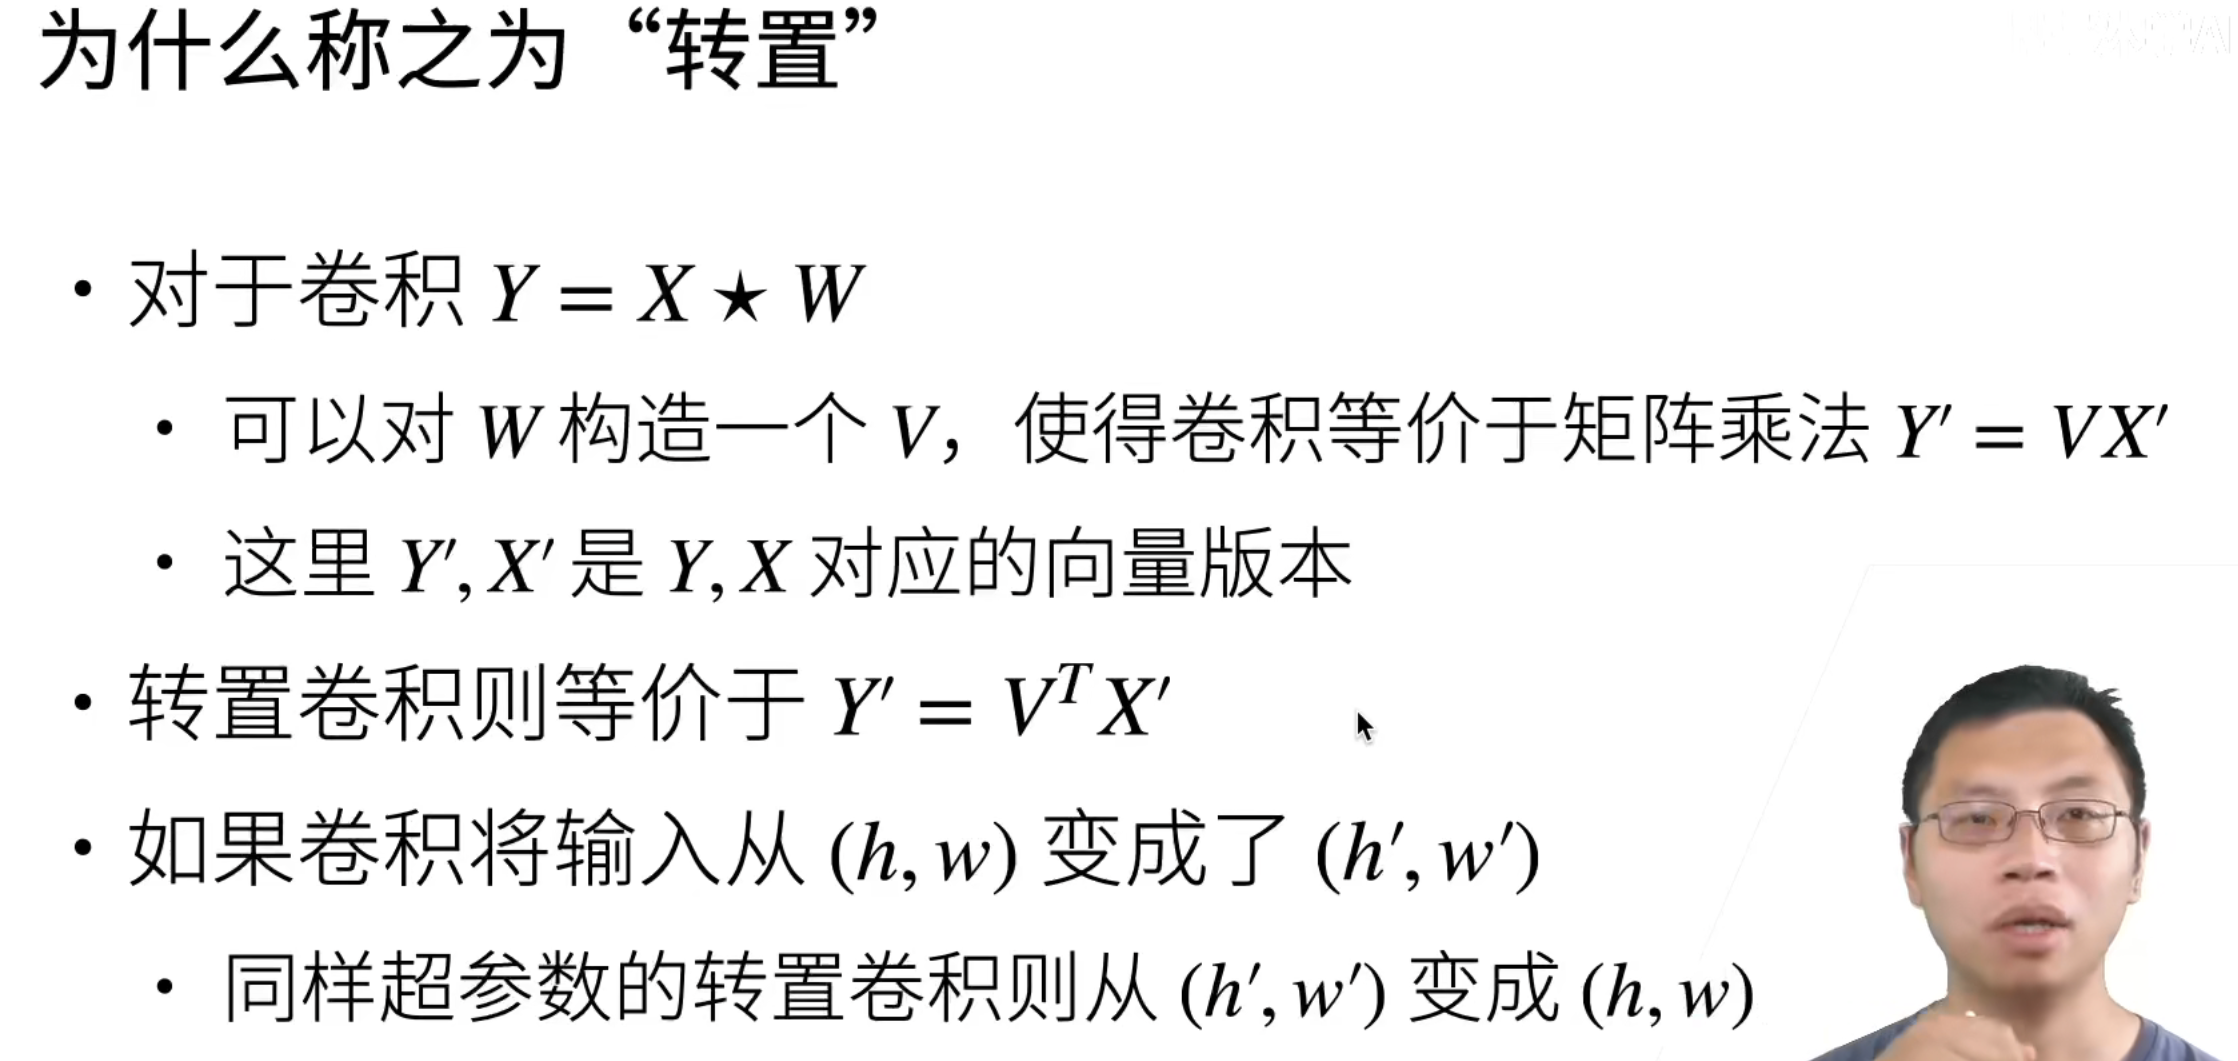

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 基本操作

让我们暂时忽略通道，从基本的转置卷积开始，设步幅为1且没有填充。
假设我们有一个$n_h \times n_w$的输入张量和一个$k_h \times k_w$的卷积核。
以步幅为1滑动卷积核窗口，每行$n_w$次，每列$n_h$次，共产生$n_h n_w$个中间结果。
每个中间结果都是一个$(n_h + k_h - 1) \times (n_w + k_w - 1)$的张量，初始化为0。
为了计算每个中间张量，输入张量中的每个元素都要乘以卷积核，从而使所得的$k_h \times k_w$张量替换中间张量的一部分。
请注意，每个中间张量被替换部分的位置与输入张量中元素的位置相对应。
最后，所有中间结果相加以获得最终结果。

例如， :numref:`fig_trans_conv`解释了如何为$2\times 2$的输入张量计算卷积核为$2\times 2$的转置卷积。

![卷积核为 $2\times 2$ 的转置卷积。阴影部分是中间张量的一部分，也是用于计算的输入和卷积核张量元素。 ](../img/trans_conv.svg)
:label:`fig_trans_conv`

我们可以对输入矩阵`X`和卷积核矩阵`K`(**实现基本的转置卷积运算**)`trans_conv`。


In [2]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

与通过卷积核“减少”输入元素的常规卷积（在 :numref:`sec_conv_layer`中）相比，转置卷积通过卷积核“广播”输入元素，从而产生大于输入的输出。
我们可以通过 :numref:`fig_trans_conv`来构建输入张量`X`和卷积核张量`K`从而[**验证上述实现输出**]。
此实现是基本的二维转置卷积运算。


In [3]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

或者，当输入`X`和卷积核`K`都是四维张量时，我们可以[**使用高级API获得相同的结果**]。


In [4]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

## [**填充、步幅和多通道**]

与常规卷积不同，在转置卷积中，填充被应用于的输出（常规卷积将填充应用于输入）。
例如，当将高和宽两侧的填充数指定为1时，转置卷积的输出中将删除第一和最后的行与列。


In [5]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<SlowConvTranspose2DBackward>)

在转置卷积中，步幅被指定为中间结果（输出），而不是输入。
使用 :numref:`fig_trans_conv`中相同输入和卷积核张量，将步幅从1更改为2会增加中间张量的高和权重，因此输出张量在 :numref:`fig_trans_conv_stride2`中。

![卷积核为$2\times 2$，步幅为2的转置卷积。阴影部分是中间张量的一部分，也是用于计算的输入和卷积核张量元素。](../img/trans_conv_stride2.svg)
:label:`fig_trans_conv_stride2`

以下代码可以验证 :numref:`fig_trans_conv_stride2`中步幅为2的转置卷积的输出。


In [6]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

对于多个输入和输出通道，转置卷积与常规卷积以相同方式运作。
假设输入有$c_i$个通道，且转置卷积为每个输入通道分配了一个$k_h\times k_w$的卷积核张量。
当指定多个输出通道时，每个输出通道将有一个$c_i\times k_h\times k_w$的卷积核。

同样，如果我们将$\mathsf{X}$代入卷积层$f$来输出$\mathsf{Y}=f(\mathsf{X})$，并创建一个与$f$具有相同的超参数、但输出通道数量是$\mathsf{X}$中通道数的转置卷积层$g$，那么$g(Y)$的形状将与$\mathsf{X}$相同。
下面的示例可以解释这一点。


In [7]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape # 反函数

True

## [**与矩阵变换的联系**]
:label:`subsec-connection-to-mat-transposition`

转置卷积为何以矩阵变换命名呢？
让我们首先看看如何使用矩阵乘法来实现卷积。
在下面的示例中，我们定义了一个$3\times 3$的输入`X`和$2\times 2$卷积核`K`，然后使用`corr2d`函数计算卷积输出`Y`。


In [8]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

接下来，我们将卷积核`K`重写为包含大量0的稀疏权重矩阵`W`。
权重矩阵的形状是（$4$，$9$），其中非0元素来自卷积核`K`。


In [9]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

逐行连结输入`X`，获得了一个长度为9的矢量。
然后，`W`的矩阵乘法和向量化的`X`给出了一个长度为4的向量。
重塑它之后，可以获得与上面的原始卷积操作所得相同的结果`Y`：我们刚刚使用矩阵乘法实现了卷积。


In [10]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

同样，我们可以使用矩阵乘法来实现转置卷积。
在下面的示例中，我们将上面的常规卷积$2 \times 2$的输出`Y`作为转置卷积的输入。
想要通过矩阵相乘来实现它，我们只需要将权重矩阵`W`的形状转置为$(9, 4)$。


In [11]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

抽象来看，给定输入向量$\mathbf{x}$和权重矩阵$\mathbf{W}$，卷积的前向传播函数可以通过将其输入与权重矩阵相乘并输出向量$\mathbf{y}=\mathbf{W}\mathbf{x}$来实现。
由于反向传播遵循链式法则和$\nabla_{\mathbf{x}}\mathbf{y}=\mathbf{W}^\top$，卷积的反向传播函数可以通过将其输入与转置的权重矩阵$\mathbf{W}^\top$相乘来实现。
因此，转置卷积层能够交换卷积层的正向传播函数和反向传播函数：它的正向传播和反向传播函数将输入向量分别与$\mathbf{W}^\top$和$\mathbf{W}$相乘。

## 小结

* 与通过卷积核减少输入元素的常规卷积相反，转置卷积通过卷积核广播输入元素，从而产生形状大于输入的输出。
* 如果我们将$\mathsf{X}$输入卷积层$f$来获得输出$\mathsf{Y}=f(\mathsf{X})$并创造一个与$f$有相同的超参数、但输出通道数是$\mathsf{X}$中通道数的转置卷积层$g$，那么$g(Y)$的形状将与$\mathsf{X}$相同。
* 我们可以使用矩阵乘法来实现卷积。转置卷积层能够交换卷积层的正向传播函数和反向传播函数。

## 练习

1. 在 :numref:`subsec-connection-to-mat-transposition`中，卷积输入`X`和转置的卷积输出`Z`具有相同的形状。他们的数值也相同吗？为什么？
1. 使用矩阵乘法来实现卷积是否有效率？为什么？ 

1.数值不同，不可逆，形状可逆      
2.效率高。原因：
①普通卷积操作的前向传播通过矩阵乘法一次实现，而非形式上的卷积核进行卷积并平移
②普通卷积操作的反向传播是输入乘转置权重矩阵
③上述代码表明，转置卷积作用实质上也是矩阵乘法，其前向传播为普通卷积的反向传播，反向传播同